Model Workflow
Data Loading &  Processing
()


Data source: ccxt for real-time and historical data on OHLCV(open, high, low, closing & volume data) for digital currency (e.g. BTC) using a 1d (daily) timeframe 
Feature Engineering : calculate price, volume & volatility-based indicators 
- Price: Simple Moving Average(SMA), EMA, RSI, MACD (for momentum signals)
--> RSI: measure 
- Volume: OBV (On-Balance Volume), Money Flow Index (MFI)
- Volatility: ATR (Average True Range), Bollinger Bands Width(BBW)

Further Feature engineering: implementing Time Series 

- Add weighted averages based on regression of lagged values, using partial autocorrelation (PACF) to identify autoregressive lags for feature selection
- Implement time-series modelling to forecast short-term price movements using ARIMA, & selecting best ARIMA model based on AIC/BIC criteria to obtain parameters (p - autoregressive order & q - simple moving average order)
Filling missing data with interpolation & normalization

Feature Selection through Pre-calculated Technical Indicators 

Trend prediction: inputs - SMA, EMA, using Linear regression (OLS), or support vector machine
Market Regime Detection: inputs - RSI, ATR, SMA using K-means Clustering
Buy/Sell Signals for Binary Classification: inputs - RSI, MACD, OBV, using Random Forest Classifier 

Model Training & Prediction: Machine Learning

Time Series Modelling: ARIMA for short -term price, GARCH for volatility forecasting 
Price Forecasting: LSTM, utilizing keras to implement long-term price forecasting
Strategy Implementation:
Combine signals and implement reinforcement learning to create a trading strategy

Momentum Oscillators(BUY/SELL SIGNALS)
RSI: 
Purpose: Measures the speed & change of price movements.
Use Case: Buy if RSI < 30 (oversold), Sell if RSI > 70 (overbought)
MACD:
Purpose: Identifies trend reversals via moving average crossovers.
Use Case: Buy if MACD crosses above Signal Line, Sell if MACD crosses below Signal Line
(other indicators we have not considered)
Stochastic Oscillator(STOCH)
Purpose: Identifies overbought & oversold conditions based on recent highs/lows.
Use Case: Buy if %K crosses above %D in oversold zone (<20), Sell if %K crosses below %D in overbought zone (>80)
Rate of Change (ROC)
Purpose: Measures the percentage change of price over a given period.
Use Case: Buy when ROC turns positive, Sell when ROC turns negative.

Volitility Indicators 
Bollinger Bands:
Purpose: Measures price volatility relative to a moving average.
Use Case: Buy when price touches lower band, Sell when price touches upper band.
Average True Range (ATR)
Purpose: Measures market volatility by averaging true range values.
Use Case: High ATR → High volatility, Low ATR → Low volatility.

Volume Indicators 
On-Balance Volume (OBV)
Purpose: Cumulative volume indicator that tracks buying/selling pressure.
Use Case: Rising OBV suggests buying pressure, declining OBV suggests selling pressure.
Money Flow Index (MFI)
Purpose: Volume-weighted RSI to assess buying/selling pressure.
Use Case: Buy if MFI < 20, Sell if MFI > 80


In [1]:
#Data Loading
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1d'

# Calculate timestamp for 1 year ago 
end_date = datetime(2025, 2, 28)  # Last day of February 2025
start_date = end_date - timedelta(days=365)  

# Convert to milliseconds (Binance API uses Unix timestamp in milliseconds)
since = int(start_date.timestamp() * 1000)

# Fetch historical OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Convert to DataFrame
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

# Display the first few rows
print(data.head())
print(data.tail())  # Check the latest date to ensure correct range


                open      high       low     close       volume
timestamp                                                      
2024-02-29  62432.11  63676.35  60364.70  61130.98  78425.07603
2024-03-01  61130.99  63114.23  60777.00  62387.90  47737.93473
2024-03-02  62387.90  62433.19  61561.12  61987.28  25534.73659
2024-03-03  61987.28  63231.88  61320.00  63113.97  28994.90903
2024-03-04  63113.97  68499.00  62300.00  68245.71  84835.16005
                open      high       low     close       volume
timestamp                                                      
2025-03-16  84338.44  85117.04  81981.12  82574.53  17596.12531
2025-03-17  82574.52  84756.83  82456.00  84010.03  17214.74358
2025-03-18  84010.02  84021.74  81134.66  82715.03  17610.89883
2025-03-19  82715.03  87000.00  82547.16  86845.94  28151.05374
2025-03-20  86845.93  87453.67  84755.14  85342.61  10061.87862


In [2]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA_5'] = SMAIndicator(data['close'], window=5).sma_indicator()
    data['SMA_10'] = SMAIndicator(data['close'], window=10).sma_indicator()
    data['SMA_15'] = SMAIndicator(data['close'], window=15).sma_indicator()
    data['SMA_30'] = SMAIndicator(data['close'], window=30).sma_indicator()
    data['EMA_9'] = EMAIndicator(data['close'], window=9).ema_indicator()
    data['RSI'] = RSIIndicator(data['close'], window=14).rsi()
    macd = MACD(data['close'], window_fast=12, window_slow=26, window_sign=9)
    data['MACD'] = macd.macd() 
    data['MACD_signal'] = macd.macd_signal()
    data['MACD_hist'] = macd.macd_diff()
    # Lagged Close prices
    data['close_lag_1'] = data['close'].shift(1)
    data['close_lag_2'] = data['close'].shift(2)
    for n in [1, 2, 5, 10, 20, 30]:
        data[f'close_{n}_ahead'] = data['close'].shift(-n)
    data['log_return'] = np.log(data['close']).diff()
    
    return data 

#handle missing values
def handle_missing_data(data):
    data.ffill(inplace=True)
    data.bfill(inplace = True)
    return data 

# Normalization
def normalize_data(df):
    scaler = StandardScaler()
    df[['SMA', 'EMA', 'MACD', 'OBV', 'ATR']] = scaler.fit_transform(df[['SMA', 'EMA', 'MACD', 'OBV', 'ATR']])
    return df

btc_data = calculate_technical_indicators(data)
btc_data = handle_missing_data(btc_data)
# btc_data = normalize_data(btc_data)

#inspect data
print(btc_data.head()) 
print(btc_data.tail())


                open      high       low     close       volume      SMA_5  \
timestamp                                                                    
2024-02-29  62432.11  63676.35  60364.70  61130.98  78425.07603  63373.168   
2024-03-01  61130.99  63114.23  60777.00  62387.90  47737.93473  63373.168   
2024-03-02  62387.90  62433.19  61561.12  61987.28  25534.73659  63373.168   
2024-03-03  61987.28  63231.88  61320.00  63113.97  28994.90903  63373.168   
2024-03-04  63113.97  68499.00  62300.00  68245.71  84835.16005  63373.168   

               SMA_10        SMA_15        SMA_30         EMA_9  ...  \
timestamp                                                        ...   
2024-02-29  64992.452  67124.790667  67264.025667  65149.020094  ...   
2024-03-01  64992.452  67124.790667  67264.025667  65149.020094  ...   
2024-03-02  64992.452  67124.790667  67264.025667  65149.020094  ...   
2024-03-03  64992.452  67124.790667  67264.025667  65149.020094  ...   
2024-03-04  64992.452

In [3]:
print(btc_data.columns)
# check if there are any missing values
print(btc_data.isnull().sum())

Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15',
       'SMA_30', 'EMA_9', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist',
       'close_lag_1', 'close_lag_2', 'close_1_ahead', 'close_2_ahead',
       'close_5_ahead', 'close_10_ahead', 'close_20_ahead', 'close_30_ahead',
       'log_return'],
      dtype='object')
open              0
high              0
low               0
close             0
volume            0
SMA_5             0
SMA_10            0
SMA_15            0
SMA_30            0
EMA_9             0
RSI               0
MACD              0
MACD_signal       0
MACD_hist         0
close_lag_1       0
close_lag_2       0
close_1_ahead     0
close_2_ahead     0
close_5_ahead     0
close_10_ahead    0
close_20_ahead    0
close_30_ahead    0
log_return        0
dtype: int64


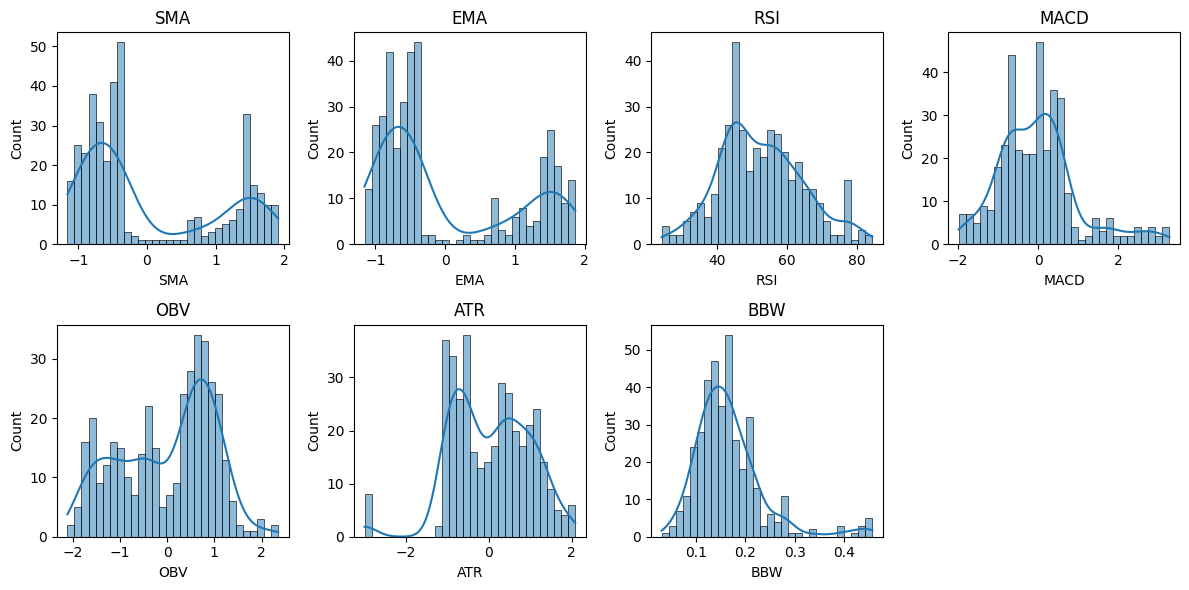

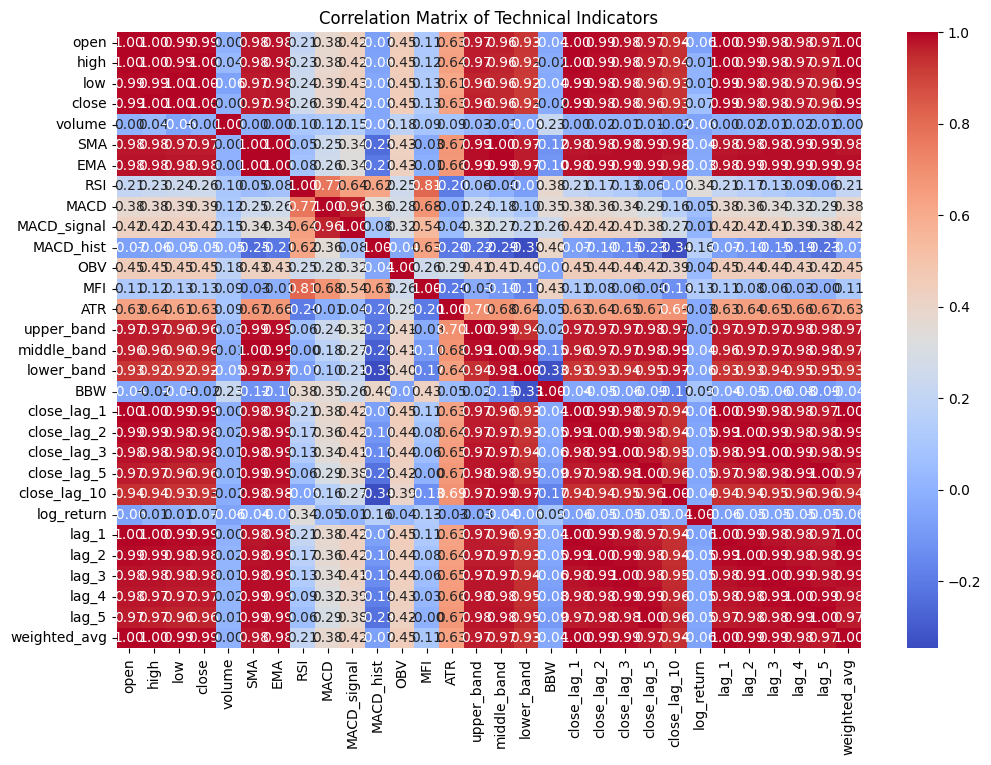

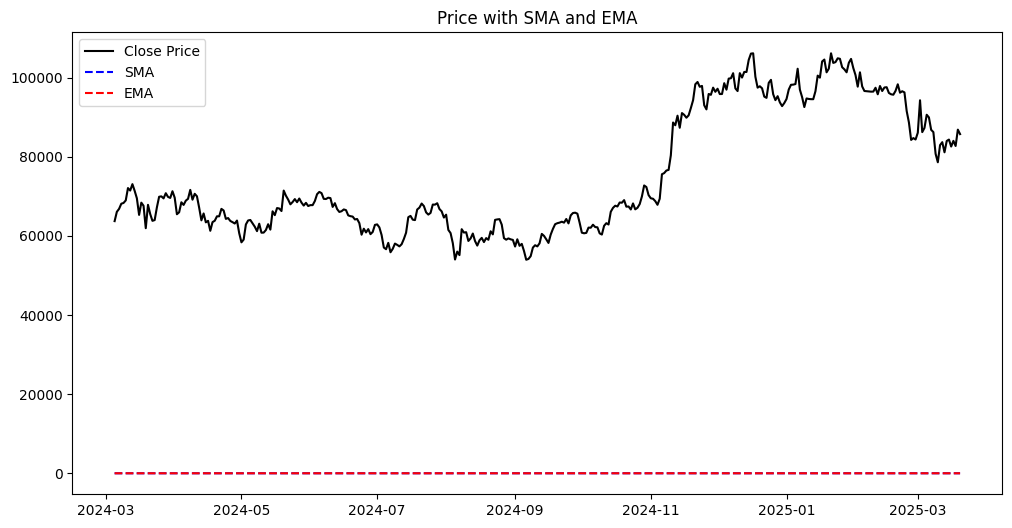

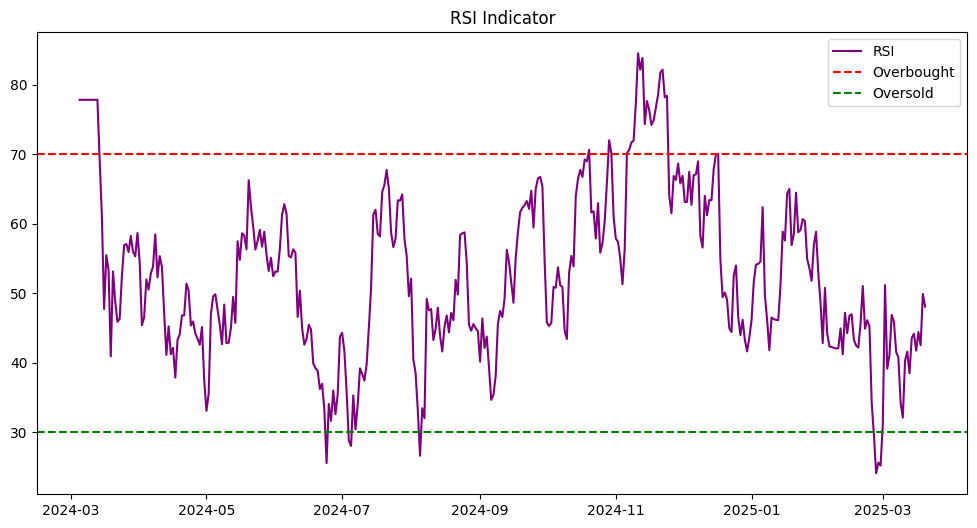

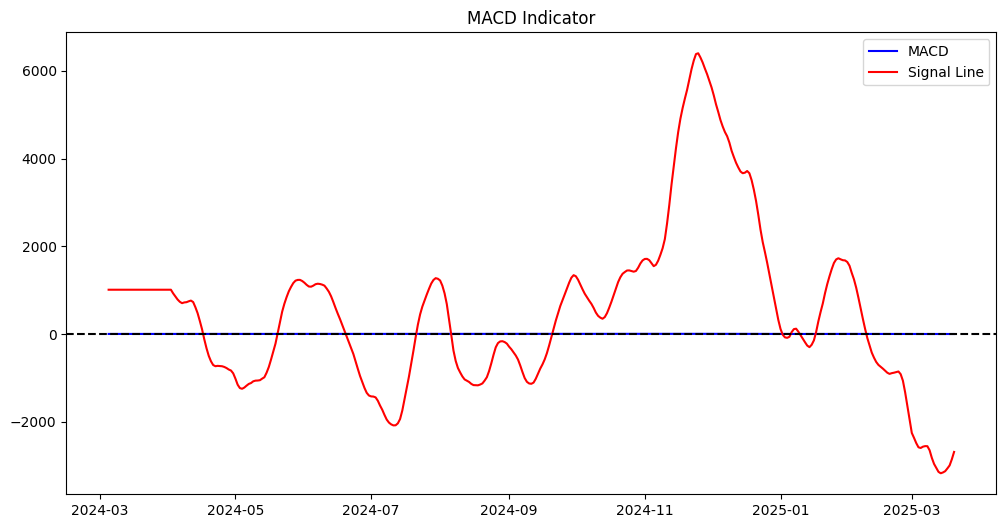

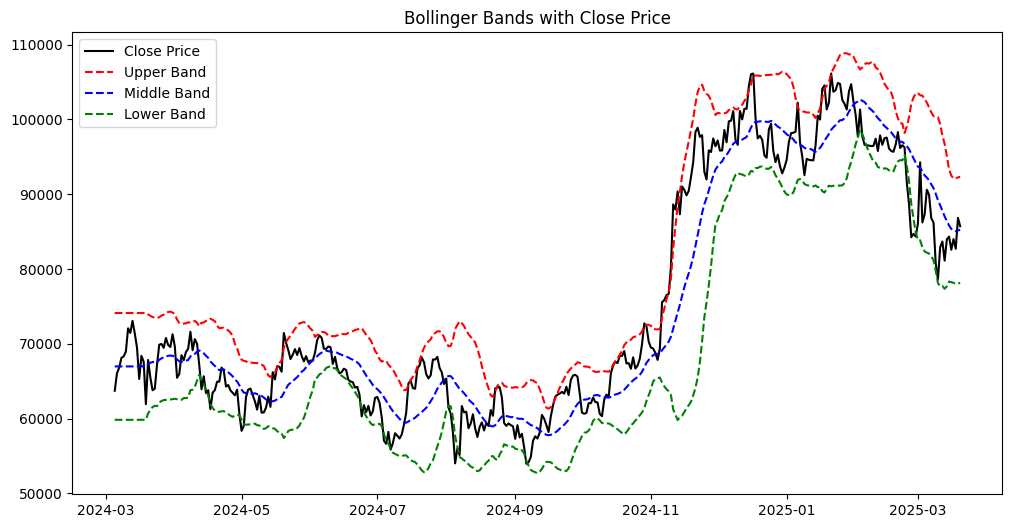

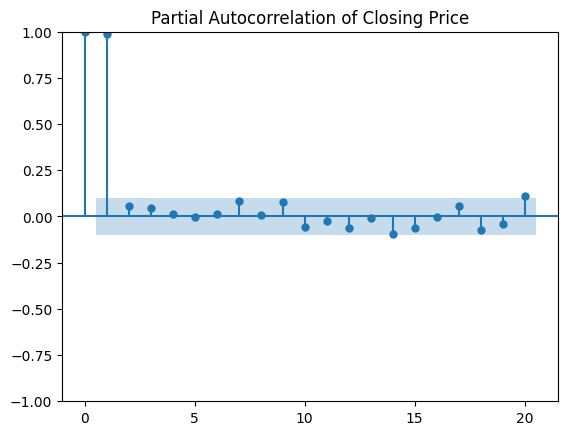

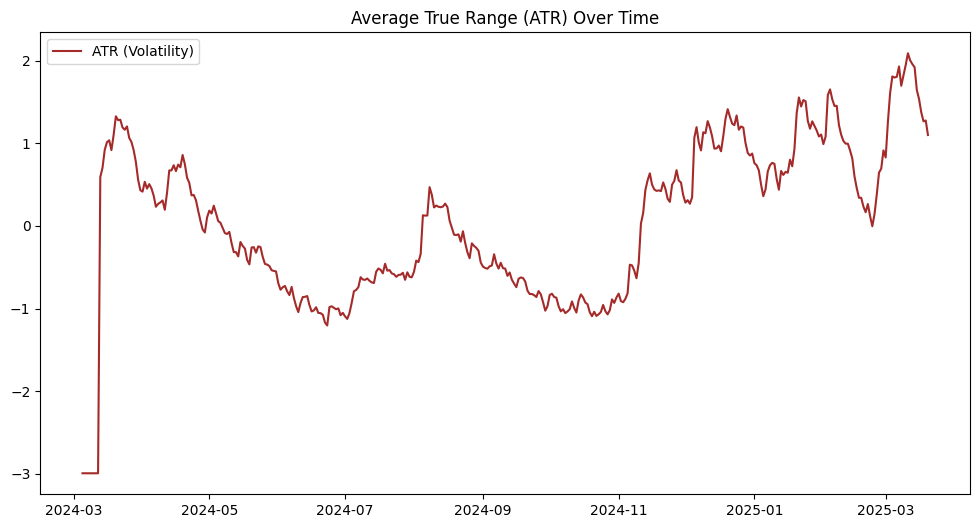

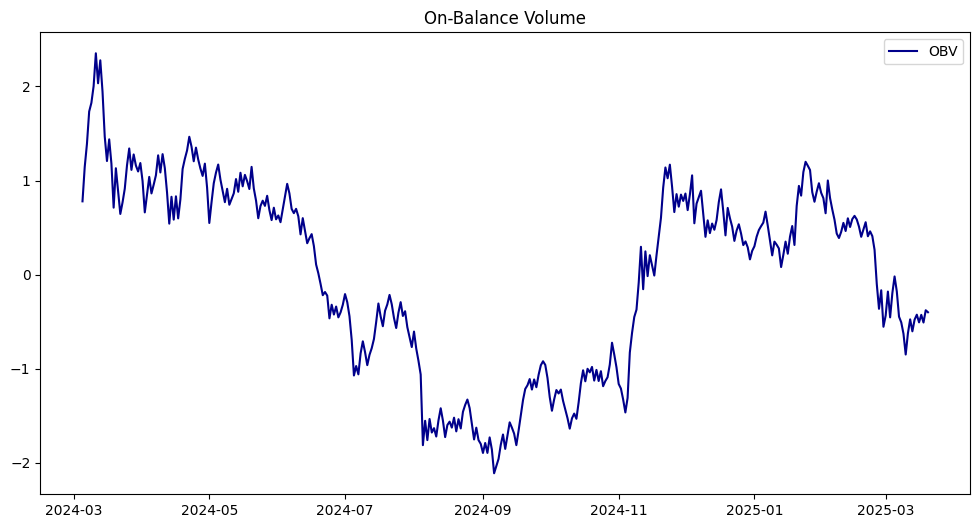

In [ ]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt 

data = btc_data

#Distribution of Each Indicaor 
indicators = ['SMA', 'EMA', 'RSI', 'MACD']  # Select key indicators

plt.figure(figsize=(12, 6))
for i, indicator in enumerate(indicators):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data[indicator], kde=True, bins=30)
    plt.title(indicator)
plt.tight_layout()
plt.show()

#Check for Correlations(Feature Redundancy)
#Some indicators might be highly correlated, making them redundant
#If correlation > 0.85, remove one of the correlated features.
# Example: SMA and EMA are usually correlated → Keep only one.
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Technical Indicators")
plt.show()

#Comparing Indicators with closing prices (Plot Trends Over Time)
# Check how SMA and EMA interact with price.
# Identify points where indicators signal trend reversals.

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='black')
plt.plot(data.index, data['SMA'], label='SMA', linestyle='dashed', color='blue')
plt.plot(data.index, data['EMA'], label='EMA', linestyle='dashed', color='red')
plt.legend()
plt.title("Price with SMA and EMA")
plt.show()

#Identify Overbought & Oversold Conditions (RSI & MACS)
# A. RSI (Relative Strength Index)
# RSI > 70 → Overbought (possible sell signal)
# RSI < 30 → Oversold (possible buy signal)
# Are most RSI values in a normal range (30-70)?
# Do RSI peaks align with price reversals?
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RSI'], label="RSI", color="purple")
plt.axhline(70, linestyle="dashed", color="red", label="Overbought")
plt.axhline(30, linestyle="dashed", color="green", label="Oversold")
plt.legend()
plt.title("RSI Indicator")
plt.show()

# B. MACD (Moving Average Convergence Divergence)
# MACD > Signal Line → Bullish
# MACD < Signal Line → Bearish
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['MACD'], label='MACD', color='blue')
plt.plot(data.index, data['MACD_signal'], label='Signal Line', color='red')
plt.axhline(0, linestyle="dashed", color="black")
plt.legend()
plt.title("MACD Indicator")
plt.show()

#Aurocorrelation & Seasonality
#Check if past price values influence future prices using Partial Autocorrelation (PACF).
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['close'], lags=20)
plt.title("Partial Autocorrelation of Closing Price")
plt.show()

# XGBoost

In [4]:
print(btc_data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15',
       'SMA_30', 'EMA_9', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist',
       'close_lag_1', 'close_lag_2', 'close_1_ahead', 'close_2_ahead',
       'close_5_ahead', 'close_10_ahead', 'close_20_ahead', 'close_30_ahead',
       'log_return'],
      dtype='object')


In [5]:
from sklearn.model_selection import train_test_split

# Features and target
features = ['SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'MACD', 'MACD_signal', 'RSI', 'close_lag_1', 'close_lag_2']
targets = ['close_1_ahead', 'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead', 'close_30_ahead']

# Split the data
train_data, test_data = train_test_split(data, test_size=0.15, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.15, shuffle=False)

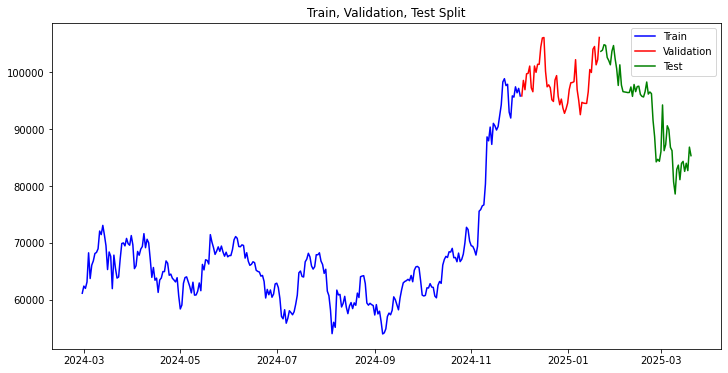

In [7]:
# visualise the train, validation and test data
# train is first 8 months
# validation is next 2 month
# test is last 2 months
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['close'], label='Train', color='blue')
plt.plot(val_data.index, val_data['close'], label='Validation', color='red')
plt.plot(test_data.index, test_data['close'], label='Test', color='green')
plt.legend()
plt.title("Train, Validation, Test Split")
plt.show()

In [10]:
# Plot BTC price development candlestick chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['open'], high=data['high'], low=data['low'], close=data['close'])])
fig.update_layout(title='BTC/USDT Price Development', xaxis_title='Date', yaxis_title='Price')
#theme minimal
fig.update_layout(template='simple_white')
fig.show()


### Hyperparameter Tuning

Grid Search CV

In [49]:
# grid search for best hyperparameters for XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
model = XGBRegressor()

# Define hyperparameters
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 11, 13, 14],
    'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.2, 0.4, 0.7],
    'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6],
    'reg_alpha': [0.4, 0.8, 1.6, 6.4],
    'reg_lambda': [0.4, 0.8, 1.6, 6.4]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_data[features], train_data[targets[0]])


KeyboardInterrupt: 

Random Search CV

In [50]:
# random search for best hyperparameters for XGBoost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the model
model = XGBRegressor()

param_distributions = {
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.7),
    'gamma': uniform(0, 2),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(0, 10)
}

# Perform random search
random_search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=5, scoring='neg_mean_squared_error')
random_search.fit(train_data[features], train_data[targets[0]])

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BBFF9634F0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BBE93034C0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BBFF963610>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BBFF95BE50>},
                   scoring='neg_mean_squared_error')

Bayesian Optimization

In [ ]:
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'learning_rate': Real(0.01, 0.7, prior='log-uniform'),
    'max_depth': Integer(5, 14),
    'gamma': Real(0, 1.6),
    'alpha': Real(0.4, 6.4),
    'lambda': Real(0.4, 6.4),
}

# Bayesian Optimization
opt = BayesSearchCV(model, search_space, n_iter=50, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
opt.fit(train_data[features], train_data['close_1_ahead'])

# Best hyperparameters
best_params = opt.best_params_

# Train the model with the best hyperparameters
model = XGBRegressor(**best_params, objective='reg:squarederror', n_estimators=50, random_state=42)
model.fit(train_data[features], train_data['close_1_ahead'])

### Develop Trading Strategy

In [ ]:
# Predict future prices
train_data['Pred_1_day'] = model.predict(train_data[features])
val_data['Pred_1_day'] = model.predict(val_data[features])
test_data['Pred_1_day'] = model.predict(test_data[features])



In [48]:
from skopt import gp_minimize

# Define the objective function for weight optimization
def objective(weights):
    # Combine predictions using the weights
    combined_pred = (weights[0] * train_data['Pred_1_day'] +
                     weights[1] * train_data['Pred_2_day'] +
                     weights[2] * train_data['Pred_5_day'] +
                     weights[3] * train_data['Pred_10_day'] +
                     weights[4] * train_data['Pred_20_day'] +
                     weights[5] * train_data['Pred_30_day'])
    
    # Calculate the Sharpe ratio (or any other metric)
    returns = combined_pred.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std()
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

# Define the search space for weights
weight_space = [(0, 1) for _ in range(6)]

# Bayesian Optimization for weight optimization
res = gp_minimize(objective, weight_space, n_calls=50, random_state=42)
best_weights = res.x

KeyError: 'Pred_2_day'

## ARIMA

Preprocess Data

In [21]:
# Create a new DataFrame with a clone of btc_data including the timestamp column
arima_df = btc_data[['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'OBV', 'MFI', 'ATR', 'upper_band', 'middle_band', 'lower_band', 'BBW', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'weighted_avg']].copy()
arima_df.reset_index(inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...    upper_band  middle_band  \
0 -145.010934  0.777210  80.743988  ...  74118.585226   66980.6605   
1 -145.010934  1.141570  80.743988  ...  74118.585226   66980.6605   
2 -145.010934  1.387102  80.743988  ...  74118.585226   66980.6605   
3 -145.010934  1.730745  80.743988  ...  74118.585226   66980.6605   
4 -145.010934  1.822706  80.743988  ...  74118.585226   66980.6605   

     lower_band       BBW     lag_1     lag_2     lag_3     lag_4     lag_5  \
0  59842.735774  0.

In [22]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Assuming 'data' is your DataFrame and 'date' is your timestamp column
arima_df['timestamp'] = pd.to_datetime(arima_df['timestamp'])  # Ensure date column is datetime
arima_df.set_index('timestamp', inplace=True)

# Check for missing values and fill them if needed
arima_df = arima_df.fillna(method='ffill') # Forward fill missing values

# Perform Augmented Dickey-Fuller test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Check stationarity on 'close' price
adf_test(arima_df['close'])


ADF Statistic: -1.3102930665164187
p-value: 0.6244501652162752
The series is non-stationary.


C:\Users\ryant\AppData\Local\Temp\ipykernel_27940\3696961266.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arima_df = arima_df.fillna(method='ffill') # Forward fill missing values


Difference the df to make it stationary

In [23]:
# First-order differencing to make the series stationary
arima_df['close_diff'] = arima_df['close'] - arima_df['close'].shift(1)

# Perform the ADF test again on the differenced series
adf_test(arima_df['close_diff'].dropna())

ADF Statistic: -20.611240059895128
p-value: 0.0
The series is stationary.


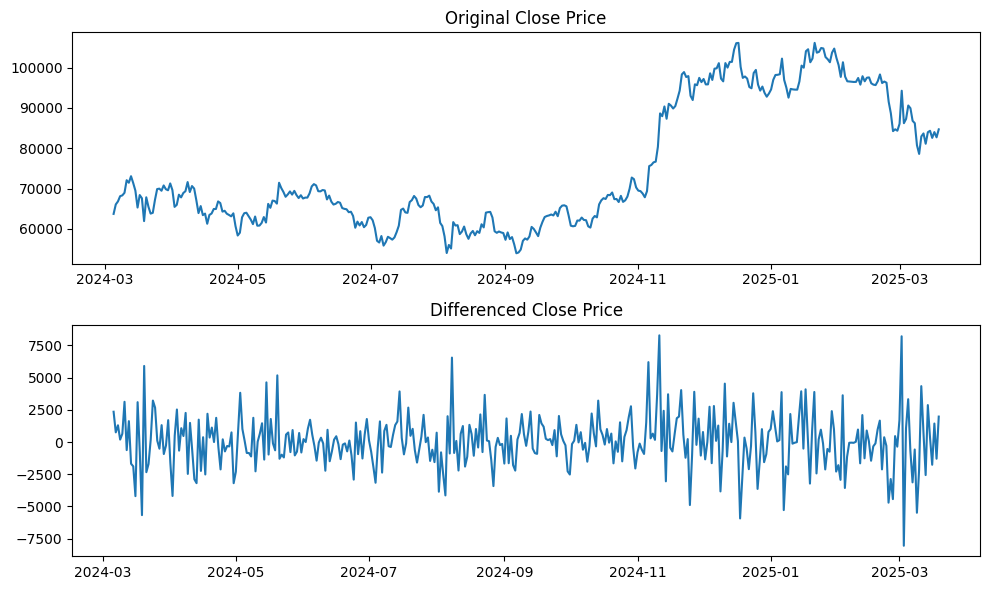

In [24]:
# Plot original data and differenced data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(arima_df['close'])
plt.title('Original Close Price')

plt.subplot(2, 1, 2)
plt.plot(arima_df['close_diff'])
plt.title('Differenced Close Price')
plt.tight_layout()
plt.show()


In [ ]:
arima_df.reset_index(inplace=True)
# drop index column

print(arima_df.head())

   index  timestamp     close       SMA       EMA        RSI      MACD  \
0      0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483   
1      1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483   
2      2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483   
3      3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483   
4      4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483   

   MACD_signal   MACD_hist       OBV  ...  middle_band    lower_band  \
0  1008.875495 -145.010934  0.777210  ...   66980.6605  59842.735774   
1  1008.875495 -145.010934  1.141570  ...   66980.6605  59842.735774   
2  1008.875495 -145.010934  1.387102  ...   66980.6605  59842.735774   
3  1008.875495 -145.010934  1.730745  ...   66980.6605  59842.735774   
4  1008.875495 -145.010934  1.822706  ...   66980.6605  59842.735774   

        BBW     lag_1     lag_2     lag_3     lag_4     lag_5  weighted_avg  \
0  0.213134  68245.71  63113.97  61987.28  

In [27]:
arima_df.drop(columns=['index'], inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...  middle_band    lower_band       BBW  \
0 -145.010934  0.777210  80.743988  ...   66980.6605  59842.735774  0.213134   
1 -145.010934  1.141570  80.743988  ...   66980.6605  59842.735774  0.213134   
2 -145.010934  1.387102  80.743988  ...   66980.6605  59842.735774  0.213134   
3 -145.010934  1.730745  80.743988  ...   66980.6605  59842.735774  0.213134   
4 -145.010934  1.822706  80.743988  ...   66980.6605  59842.735774  0.213134   

      lag_1     lag_2     lag_3     la

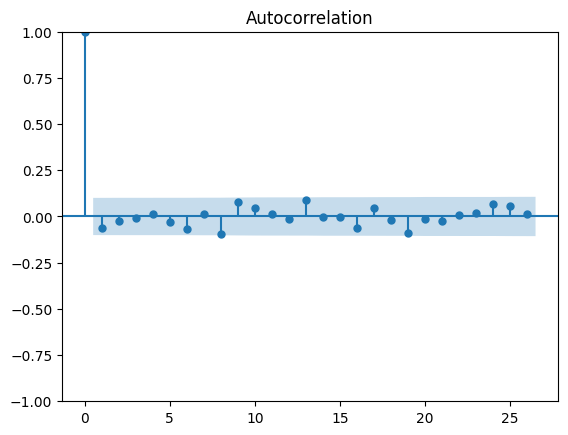

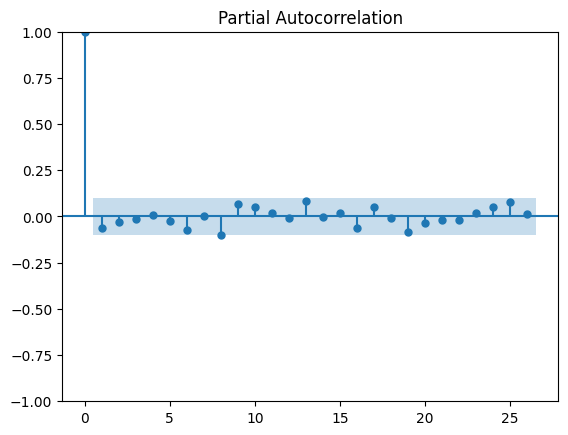

In [28]:
# Plot ACF and PACF for determining p and q
plot_acf(arima_df['close_diff'].dropna())  # ACF plot
plot_pacf(arima_df['close_diff'].dropna())  # PACF plot
plt.show()


In [29]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(arima_df['close'], order=(1, 1, 1))  # (p, d, q)
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  380
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3426.834
Date:                Thu, 20 Mar 2025   AIC                           6859.668
Time:                        00:31:07   BIC                           6871.480
Sample:                             0   HQIC                          6864.356
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7085      1.311      0.540      0.589      -1.861       3.278
ma.L1         -0.7008      1.320     -0.531      0.595      -3.288       1.886
sigma2      4.184e+06   2.15e+05     19.474      0.0

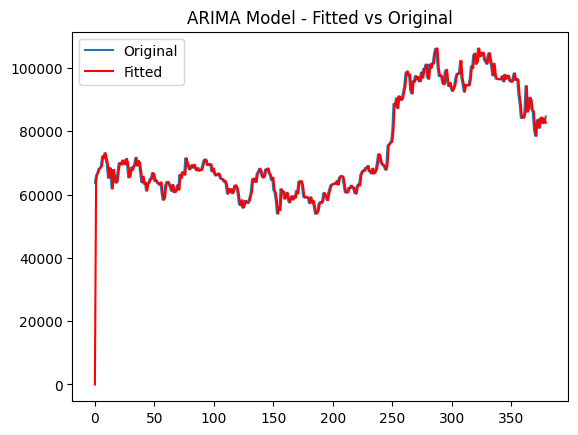

In [30]:
# Plot the forecasted values along with the original series
plt.plot(arima_df['close'], label='Original')
plt.plot(fitted_model.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title("ARIMA Model - Fitted vs Original")
plt.show()


In [31]:
# Forecast the next 10 periods (e.g., days)
forecast = fitted_model.forecast(steps=10)

# Print the forecasted values
print(forecast)


380    84700.285519
381    84708.217584
382    84713.837480
383    84717.819195
384    84720.640255
385    84722.638985
386    84724.055093
387    84725.058410
388    84725.769264
389    84726.272906
Name: predicted_mean, dtype: float64


### Evaluation

In [ ]:
# Buy & Hold strategy
test_data['Buy_Hold_Returns'] = test_data['Close'].pct_change()
test_data['Cumulative_Buy_Hold_Returns'] = (1 + test_data['Buy_Hold_Returns']).cumprod()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Cumulative_Strategy_Returns'], label='Trading Strategy')
plt.plot(test_data['Cumulative_Buy_Hold_Returns'], label='Buy & Hold')
plt.legend()
plt.show()